<a href="https://colab.research.google.com/github/LukeHaberkamp/tensorflow-timeseries-essentials/blob/main/A_NextValuePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook trains a neural network to perform a next value forecast

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam

Using the logistic equation to generate timeseries data

In [3]:
def logisticEq(r, x0, N):
    x = [x0]
    for i in range(1, N):
        x_new = r * x[i-1] * (1 - x[i-1])
        x.append(x_new)
    return np.array(x)

Generate the sample data. It is necessary to add a dimension to the data to define a sequence.

In [4]:
samples = np.arange(0, 10000)

r = 4
x0 = 0.3
N = len(samples)

data = logisticEq(r=r, x0=x0, N = N) * 5
data = np.expand_dims(data, axis=1) # add dimension to define 1D data

Functions to embed the data and plot for visualization of the phase portrait

In [5]:
def TDE(x, m, tau):
    emb = np.zeros((len(x)-m*tau, m))
    for i in range(m):
        emb[:,i] = x[i*tau:(i*tau + (len(x)-m*tau))]
    return emb

In [6]:
def statespaceplot(x):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    if x.shape[1] > 2:
        ax = plt.axes(projection='3d')
        ax.scatter3D(x[:,0], x[:,1], x[:,2], alpha=0.7)
    else:
        ax = plt.axes()
        ax.scatter(x[:,0], x[:,1], alpha=0.7)
    ax.set_title('State Space')
    ax.set_xlabel("X")
    ax.set_ylabel("X'")
    ax.set_zlabel('X"')
    plt.show()

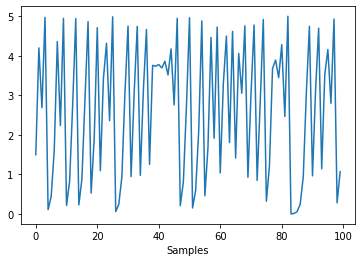

In [7]:
plt.plot(samples[:100], data[:100])
plt.xlabel("Samples")
plt.show()

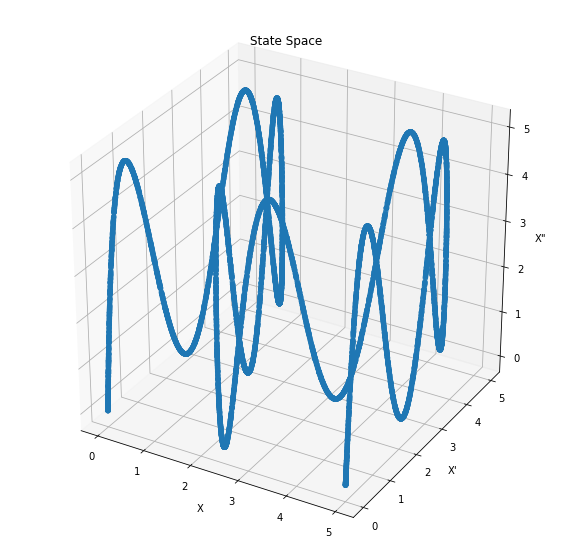

In [8]:
tde_data = TDE(data.squeeze(), m=3, tau=2)
statespaceplot(tde_data)

To prevent vanishing/expoding gradients we scale the data before into the network. StandardScaler (x - mean / std) or MinMaxScaler ((x - min) / (max - min)) work well. This is crucial for multivariate datasets.
  
We are using MinMaxScaler 

In [9]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

Next, we window the dataset to generate lots of training samples. The data is windowed to predict the next sample based on the previous 32 observations. Note the weird python indexing here.

In [10]:
# prepare data
window_size = 32

x = []
y = []
for i in range(window_size, scaled_data.shape[0]):
    x.append(scaled_data[i-window_size:i])
    y.append(scaled_data[i])

x = np.array(x)
y = np.array(y)

Split the data into training and validation

In [11]:
cutoff = round(0.8 * x.shape[0])

x_train = x[:cutoff]
y_train = y[:cutoff]

x_val = x[cutoff:]
y_val = y[cutoff:]

print("Training Inputs Shape:", x_train.shape)
print("Training Outputs Shape:", y_train.shape)

print("\nValidation Inputs Shape:", x_val.shape)
print("Validation Outputs Shape:", y_val.shape)

Training Inputs Shape: (7974, 32, 1)
Training Outputs Shape: (7974, 1)

Validation Inputs Shape: (1994, 32, 1)
Validation Outputs Shape: (1994, 1)


In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

Build a Model with the Keras Functional API. I find this API to be the easiest for customization in complex models.

In [13]:
inputs = Input(shape=(None, x.shape[-1]))

h = LSTM(16, return_sequences=True)(inputs)
h = LSTM(16, return_sequences=False)(h)

outputs = Dense(1)(h)

model = Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 lstm (LSTM)                 (None, None, 16)          1152      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


Compile and train the model

In [14]:
optimizer = Adam(learning_rate=1e-3)
loss = 'mse'
model.compile(loss=loss, optimizer=optimizer)

In [15]:
history = model.fit(x_train,y_train,
            validation_data=(x_val,y_val),
            epochs=20,
            shuffle=True,
            batch_size=32,
            verbose=1)

Epoch 1/20
250/250 [==============================] - 19s 33ms/step - loss: 0.1376 - val_loss: 0.1263
Epoch 2/20
250/250 [==============================] - 7s 28ms/step - loss: 0.1251 - val_loss: 0.1268
Epoch 3/20
250/250 [==============================] - 7s 28ms/step - loss: 0.1248 - val_loss: 0.1254
Epoch 4/20
250/250 [==============================] - 7s 28ms/step - loss: 0.1245 - val_loss: 0.1253
Epoch 5/20
250/250 [==============================] - 7s 27ms/step - loss: 0.1247 - val_loss: 0.1252
Epoch 6/20
250/250 [==============================] - 7s 28ms/step - loss: 0.1243 - val_loss: 0.1250
Epoch 7/20
250/250 [==============================] - 7s 27ms/step - loss: 0.1234 - val_loss: 0.1236
Epoch 8/20
250/250 [==============================] - 7s 27ms/step - loss: 0.1139 - val_loss: 0.0885
Epoch 9/20
250/250 [==============================] - 7s 27ms/step - loss: 0.0314 - val_loss: 5.9912e-04
Epoch 10/20
250/250 [==============================] - 7s 28ms/step - loss: 4.4300e-04

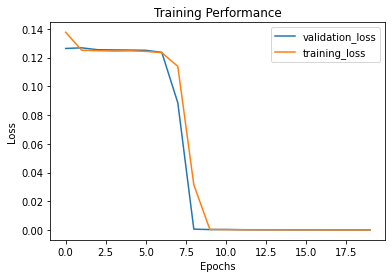

In [16]:
val_loss = history.history['val_loss']
loss = history.history['loss']

# Obtain number of epochs
epochs = range(len(loss))
# Plot loss and val loss
plt.plot(val_loss, label='validation_loss')
plt.plot(loss, label='training_loss')
plt.legend()
plt.title('Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Now evaluate the validation dataset

In [17]:
y_pred = model.predict(x_val, batch_size=32)

63/63 [==============================] - 2s 7ms/step


Call scaler.inverse_transform() to return the numeric data to the original scale

In [18]:
y_pred2 = scaler.inverse_transform(y_pred)
y_val2 = scaler.inverse_transform(y_val)

Calculate the rmse and plot for predictions vs. ground truth

RMSE = 0.042 



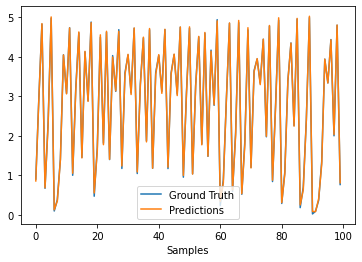

In [19]:
rmse = np.sqrt( np.mean( (y_pred2 - y_val2)**2 ) )

print("RMSE =", round(rmse,3), "\n")

plt.plot(y_val2[:100])
plt.plot(y_pred2[:100])
plt.legend(['Ground Truth', 'Predictions'])
plt.xlabel("Samples")
plt.show()